Using IterationControl.jl to control a particle tracker

In [1]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

using Plots
pyplot(size = (600, 300*(sqrt(5) -1)))

using IterationControl

 Activating environment at `~/Dropbox/Julia7/MLJ/IterationControl/examples/particle/Project.toml`


Consider an object that tracks a particle in one dimension, moving
in discrete time at a speed proportional to the distance away from
some moving target. We are viewing this particle as a toy example of
online learning and call the constant of proportionality `η` a
*learning rate*.

The particle is initially at rest at the origin, which is also where
the target begins.

Calling `train!` on the particle moves it along for the specified
number of time steps, while calling `ingest!` updates the target
position ("data ingestion").

In [2]:
mutable struct Particle
    position::Float64
    target::Float64
    velocity::Float64
    η::Float64 # learning rate
    Particle(η) = new(0.0, 0.0, 0.0, η)
end

Particle(; η=0.1) = Particle(η)

loss(model::Particle) =  abs(model.target - model.position)

loss (generic function with 1 method)

A train method for one time step:

In [3]:
function train!(model::Particle)
    model.velocity = model.η*(model.target - model.position)
    model.position = model.position + model.velocity
end

train! (generic function with 1 method)

And for multiple time steps:

In [4]:
function train!(model, n)
    foreach(1:n) do _
        train!(model)
    end
    return nothing
end

train! (generic function with 2 methods)

A method for updating the target:

In [5]:
function ingest!(model::Particle, target)
    model.target = target
    return nothing
end

ingest! (generic function with 1 method)

Lifting the `train!`, `loss` and `ingest!` methods:

In [6]:
IterationControl.train!(model::Particle, n) = train!(model, n)
IterationControl.loss(model::Particle) = loss(model)
IterationControl.ingest!(model::Particle, datum) = ingest!(model, datum)

Lets `train` our particle by alternatively setting the target
position to -1 or +1 every 5 time steps, for a total of 40 time
steps (four -1/+1 cycles). We will then then allow our particle to "cruise"
with the target fixed thereafter (the provided `data` iterator
having been exhausted). This cruising is allowed to continue until
the particle is within 0.01 of the target.

We use a learning rate of 0.1.

In [7]:
model = Particle(0.1)
data = repeat([-1, 1], outer=4)

8-element Array{Int64,1}:
 -1
  1
 -1
  1
 -1
  1
 -1
  1

┌ Info: Early stop triggered by Threshold(0.01) stopping criterion. 
└ @ IterationControl /Users/anthony/Dropbox/Julia7/MLJ/IterationControl/src/stopping_controls.jl:69


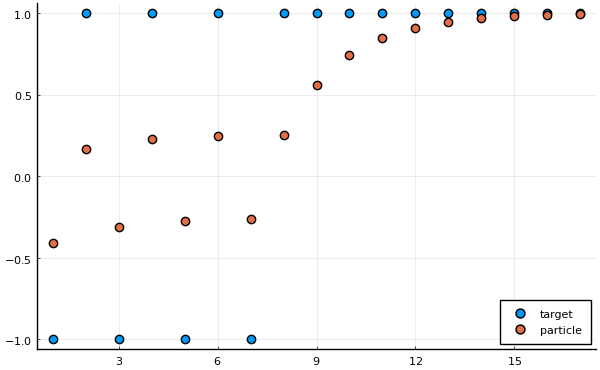

In [8]:
target_positions = Float64[]
particle_positions = Float64[]

function callback!(model)
    push!(target_positions, model.target)
    push!(particle_positions, model.position)
end

IterationControl.train!(model,
                        Data(data),
                        Step(5),
                        Callback(callback!),
                        Threshold(0.01),
                        TimeLimit(0.005));

scatter(target_positions, label="target", ms=6)
scatter!(particle_positions, label="particle", ms=6)

In [9]:
loss(model)

0.006513954865740357

Switching the target just once more to the -1 position and
continuing training until the particle and target are withing 0.01:

┌ Info: Early stop triggered by Threshold(0.01) stopping criterion. 
└ @ IterationControl /Users/anthony/Dropbox/Julia7/MLJ/IterationControl/src/stopping_controls.jl:69


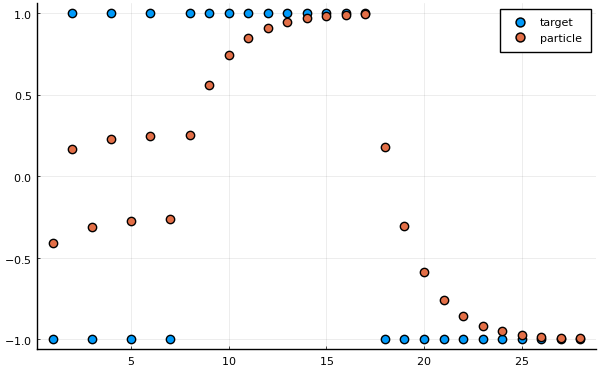

In [10]:
data = [-1,]

IterationControl.train!(model,
                        Data(data),
                        Step(5),
                        Callback(callback!),
                        Threshold(0.01),
                        TimeLimit(0.005));

scatter(target_positions, label="target", ms=6)
scatter!(particle_positions, label="particle", ms=6)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*